
Kaggle link: https://www.kaggle.com/c/predict-west-nile-virus/


Our 4th project is a group project, we were given the West Nile Virus Predicition Challenge from Kaggle https://www.kaggle.com/c/predict-west-nile-virus/ 

- Given weather, location, testing, and spraying data, predict when and where different species of mosquitos will test positive for West Nile virus.

- Analyse effectiveness of spraying

- Present in class with our findings.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime

from sklearn.cluster import DBSCAN


In [2]:
df_weather = pd.read_csv('../datasets/weather.csv')
df_spray = pd.read_csv('../datasets/spray.csv')
df_train = pd.read_csv('../datasets/train.csv')

df_test = pd.read_csv('../datasets/test.csv')

## Weather Dataset


In [3]:
#checking the size of the data for weather
df_weather.shape 

(2944, 22)

In [4]:
#check whether there is null values
df_weather.isnull().sum() 

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [5]:
df_weather
#duplicate dates(2 rows), 1472 rows missing data (50% of the data)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


Identified that two stations took the reading on the same date, we will be grouping both station data into one and aggregate it accordingly

In [6]:
#Replace "M" & "-" as null value (because they are missing data) and "  T" as 0 (because T is insignificant value i.e 0.00001)
df_weather = df_weather.replace("M", np.nan).replace("-", np.nan).replace("  T",0) 
#filling up null value with above value in other to get the mean value for grouping purpose in the later part
df_weather.fillna(method='ffill', inplace=True) #fill nan with above values as they belongs to the same date
df_weather

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,14,51,57,0,3,...,,0,NaN,0.0,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,-3,42,47,13,0,...,BR HZ,0,NaN,0.0,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,-4,34,42,20,0,...,,0,NaN,0.0,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,,0,NaN,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,-4,35,42,20,0,...,RA,0,NaN,0.0,0,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,NaN,0.1,0.03,29.49,30.20,22.6,34,22.9


In [7]:
#changing columns type to the intented data type for better analysis
df_weather = df_weather.astype({'Tavg':'float64','Depart':'float64','WetBulb':'float64','Heat':'float64','Cool':'float64','SnowFall':'float64','PrecipTotal':'float64','StnPressure':'float64','SeaLevel':'float64','AvgSpeed':'float64'})
#changing "Date" as datetime type
df_weather['Date'] = df_weather[['Date']].astype('datetime64[ns]')
df_weather


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,14.0,51,57.0,0.0,3.0,...,,0,NaN,0.0,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,-3.0,42,47.0,13.0,0.0,...,BR HZ,0,NaN,0.0,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45.0,-4.0,34,42.0,20.0,0.0,...,,0,NaN,0.0,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42.0,-4.0,34,40.0,23.0,0.0,...,,0,NaN,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45.0,-4.0,35,42.0,20.0,0.0,...,RA,0,NaN,0.0,0.00,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40.0,-6.0,25,33.0,25.0,0.0,...,RA SN,0,NaN,0.1,0.03,29.49,30.20,22.6,34,22.9


In [8]:
#Grouping with intented aggregation for individual columns
df_weather = df_weather.groupby(by="Date",as_index=False).agg({'Tmax':'mean','Tmin':'mean','Tavg':'mean','Depart':'mean','DewPoint':'mean','WetBulb':'mean','Heat':'mean','Cool':'mean',
    'SnowFall':'mean','PrecipTotal':'mean','StnPressure':'mean','SeaLevel':'mean','ResultSpeed':'mean','ResultDir':'mean','AvgSpeed':'mean',
    'Sunrise': 'first','Sunset': 'first','CodeSum':list
})
df_weather

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,CodeSum
0,2007-05-01,83.5,51.0,67.5,14.0,51.0,56.5,0.0,2.5,0.0,0.000,29.140,29.820,2.20,26.0,9.40,0448,1849,"[ , ]"
1,2007-05-02,59.5,42.5,51.5,-3.0,42.0,47.0,13.5,0.0,0.0,0.000,29.410,30.085,13.15,3.0,13.40,0447,1850,"[BR, BR HZ]"
2,2007-05-03,66.5,47.0,57.0,2.0,40.0,49.0,8.0,0.0,0.0,0.000,29.425,30.120,12.30,6.5,12.55,0446,1851,"[ , HZ]"
3,2007-05-04,72.0,50.0,58.0,4.0,41.5,50.0,7.0,0.0,0.0,0.000,29.335,30.045,10.25,7.5,10.60,0444,1852,"[RA, ]"
4,2007-05-05,66.0,53.5,60.0,5.0,38.5,49.5,5.0,0.0,0.0,0.000,29.430,30.095,11.45,7.0,11.75,0443,1853,"[ , ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78.0,52.5,65.5,16.0,51.5,58.5,0.5,1.0,0.0,0.010,28.960,29.665,12.35,19.0,13.25,0618,1653,"[ , RA]"
1468,2014-10-28,67.0,46.5,57.0,10.0,39.0,47.5,8.0,0.0,0.0,0.015,29.190,29.850,14.40,26.0,15.10,0619,1651,"[ , RA]"
1469,2014-10-29,49.0,38.0,44.0,-4.0,33.0,41.0,21.0,0.0,0.0,0.000,29.390,30.065,9.00,29.0,9.45,0620,1650,"[ , ]"
1470,2014-10-30,52.0,34.5,43.5,-4.0,34.5,41.0,21.5,0.0,0.0,0.000,29.375,30.095,5.50,23.5,6.00,0622,1649,"[ , RA]"


In [9]:
#creating function to split list into words
def apply_set(segment): 
    a = []
    for words in segment:
        a.extend(words.split())
    x = str(list(set(a)))
    
    return x.replace('[','').replace(']','').replace(' ','')

In [10]:
#apply function to split tuple into list
df_weather["CodeSum_set"] = df_weather["CodeSum"].apply(apply_set)
df_weather[["CodeSum", "CodeSum_set"]]

,CodeSum,CodeSum_set
0,"[ , ]",
1,"[BR, BR HZ]","'BR','HZ'"
2,"[ , HZ]",'HZ'
3,"[RA, ]",'RA'
4,"[ , ]",
...,...,...
1467,"[ , RA]",'RA'
1468,"[ , RA]",'RA'
1469,"[ , ]",
1470,"[ , RA]",'RA'


In [11]:
#drop unnecessary columns
df_weather.drop(columns="CodeSum",inplace=True)

df_weather

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,CodeSum_set
0,2007-05-01,83.5,51.0,67.5,14.0,51.0,56.5,0.0,2.5,0.0,0.000,29.140,29.820,2.20,26.0,9.40,0448,1849,
1,2007-05-02,59.5,42.5,51.5,-3.0,42.0,47.0,13.5,0.0,0.0,0.000,29.410,30.085,13.15,3.0,13.40,0447,1850,"'BR','HZ'"
2,2007-05-03,66.5,47.0,57.0,2.0,40.0,49.0,8.0,0.0,0.0,0.000,29.425,30.120,12.30,6.5,12.55,0446,1851,'HZ'
3,2007-05-04,72.0,50.0,58.0,4.0,41.5,50.0,7.0,0.0,0.0,0.000,29.335,30.045,10.25,7.5,10.60,0444,1852,'RA'
4,2007-05-05,66.0,53.5,60.0,5.0,38.5,49.5,5.0,0.0,0.0,0.000,29.430,30.095,11.45,7.0,11.75,0443,1853,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78.0,52.5,65.5,16.0,51.5,58.5,0.5,1.0,0.0,0.010,28.960,29.665,12.35,19.0,13.25,0618,1653,'RA'
1468,2014-10-28,67.0,46.5,57.0,10.0,39.0,47.5,8.0,0.0,0.0,0.015,29.190,29.850,14.40,26.0,15.10,0619,1651,'RA'
1469,2014-10-29,49.0,38.0,44.0,-4.0,33.0,41.0,21.0,0.0,0.0,0.000,29.390,30.065,9.00,29.0,9.45,0620,1650,
1470,2014-10-30,52.0,34.5,43.5,-4.0,34.5,41.0,21.5,0.0,0.0,0.000,29.375,30.095,5.50,23.5,6.00,0622,1649,'RA'


In [12]:
#convert datetime to Month name
df_weather['Month'] = df_weather['Date'].dt.month_name()
df_weather

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,CodeSum_set,Month
0,2007-05-01,83.5,51.0,67.5,14.0,51.0,56.5,0.0,2.5,0.0,0.000,29.140,29.820,2.20,26.0,9.40,0448,1849,,May
1,2007-05-02,59.5,42.5,51.5,-3.0,42.0,47.0,13.5,0.0,0.0,0.000,29.410,30.085,13.15,3.0,13.40,0447,1850,"'BR','HZ'",May
2,2007-05-03,66.5,47.0,57.0,2.0,40.0,49.0,8.0,0.0,0.0,0.000,29.425,30.120,12.30,6.5,12.55,0446,1851,'HZ',May
3,2007-05-04,72.0,50.0,58.0,4.0,41.5,50.0,7.0,0.0,0.0,0.000,29.335,30.045,10.25,7.5,10.60,0444,1852,'RA',May
4,2007-05-05,66.0,53.5,60.0,5.0,38.5,49.5,5.0,0.0,0.0,0.000,29.430,30.095,11.45,7.0,11.75,0443,1853,,May
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78.0,52.5,65.5,16.0,51.5,58.5,0.5,1.0,0.0,0.010,28.960,29.665,12.35,19.0,13.25,0618,1653,'RA',October
1468,2014-10-28,67.0,46.5,57.0,10.0,39.0,47.5,8.0,0.0,0.0,0.015,29.190,29.850,14.40,26.0,15.10,0619,1651,'RA',October
1469,2014-10-29,49.0,38.0,44.0,-4.0,33.0,41.0,21.0,0.0,0.0,0.000,29.390,30.065,9.00,29.0,9.45,0620,1650,,October
1470,2014-10-30,52.0,34.5,43.5,-4.0,34.5,41.0,21.5,0.0,0.0,0.000,29.375,30.095,5.50,23.5,6.00,0622,1649,'RA',October


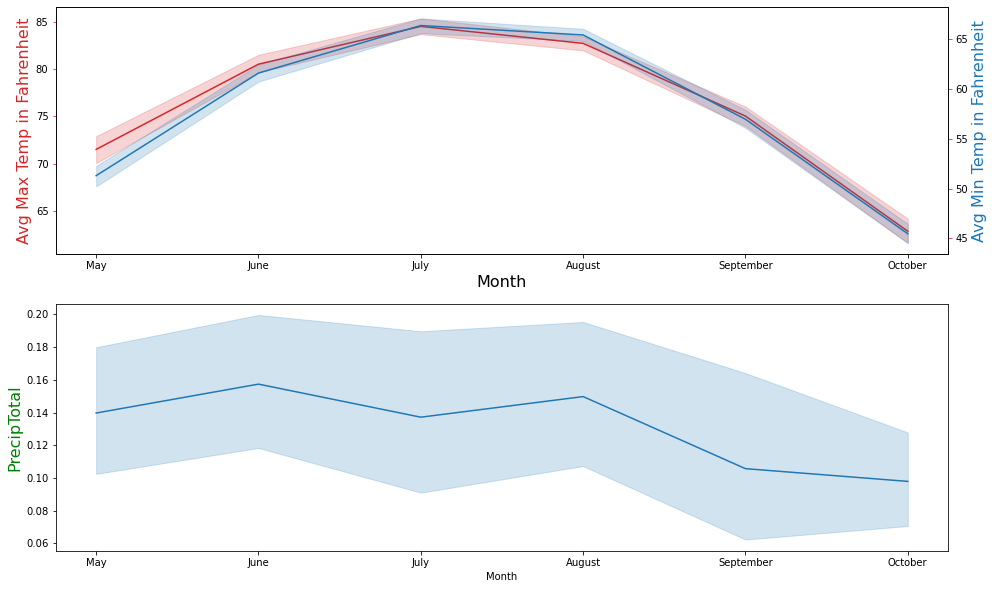

In [13]:
#Create combo chart in subplot
fig = plt.figure(figsize=(16,10))
coord1 = 211
coord2 = 212
plt.subplot(coord1)
color = 'tab:red'
#bar plot creation
#ax1.set_title('Average Temp in Fahrenheit', fontsize=16)


plt.ylabel('Avg Max Temp in Fahrenheit', fontsize=16, color=color)
ax1 = sns.lineplot(x='Month', y='Tmax', data = df_weather, sort=False, color=color)
ax1.tick_params(axis='y', color=color)
ax1.set_xlabel('Month', fontsize=16)
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color2 = 'tab:blue'
#line plot creation
ax2.set_ylabel('Avg Min Temp in Fahrenheit', fontsize=16, color=color2)
ax2 = sns.lineplot(x='Month', y='Tmin', data = df_weather, sort=False, color=color2)
ax2.tick_params(axis='y', color=color);
#show plot


plt.subplot(coord2)
sns.lineplot(data=df_weather,x='Month',y='PrecipTotal')
plt.xlabel('Month')
plt.ylabel('PrecipTotal',color='green', fontsize=16);

##### It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.Thus, from the line graph we are expecting higher infection rate between June and August since the temperature during this period is high and there is a drop in precipitation level (water vapor in the air).

In [14]:
df_weather.drop(columns=['Tmax','Tmin','Heat','Cool','SnowFall'], inplace=True)

In [15]:
df_weather["Sunrise"].isnull().sum().sum()

0

In [16]:
df_weather.to_csv("../datasets/cleaned_weather.csv", index=False)

Dropping unnecessary column to fine tune relevancy for analysis: <br>
Tmax & Tmin --> will be using average temp instead for data engineering <br>
Heat & Cool --> both factors are irrelevant as they are used to calculate energy used <br>
SnowFall & Sunrise & Sunset --> irrelevant, not an indicator that will impact West Nile virus

## Spray Dataset

In [17]:

#show sample  spray data
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [18]:
pd.DatetimeIndex(df_spray['Date']).year.value_counts()

2013    12626
2011     2209
Name: Date, dtype: int64

In [19]:
#checking data types
df_spray.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

In [20]:
#how many data poitns
df_spray.shape

(14835, 4)

In [21]:
#chek how many are NULLs
df_spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [22]:
df_spray.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

In [23]:
# Change date to date time 
df_spray['Date'] = pd.to_datetime(df_spray['Date'])

In [24]:
#Time has null values
df_spray.loc[df_spray["Time"].isnull()]

 #2011-09-07 has null time

,Date,Time,Latitude,Longitude
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
1032,2011-09-07,NaN,41.988004,-87.794574
1033,2011-09-07,NaN,41.988292,-87.795486
1034,2011-09-07,NaN,41.988100,-87.796014
...,...,...,...,...
1609,2011-09-07,NaN,41.995876,-87.811615
1610,2011-09-07,NaN,41.995972,-87.810271
1611,2011-09-07,NaN,41.995684,-87.810319
1612,2011-09-07,NaN,41.994724,-87.810415


In [25]:
#are there any duplicates?
df_spray.duplicated().sum()

541

In [26]:
# lets check for the details on the duplicates

df_spray[df_spray.duplicated() == True]

#looks like almost  all are  "2011-09-07 @7:44:32 PM"

,Date,Time,Latitude,Longitude
485,2011-09-07,7:43:40 PM,41.983917,-87.793088
490,2011-09-07,7:44:32 PM,41.986460,-87.794225
491,2011-09-07,7:44:32 PM,41.986460,-87.794225
492,2011-09-07,7:44:32 PM,41.986460,-87.794225
493,2011-09-07,7:44:32 PM,41.986460,-87.794225
...,...,...,...,...
1025,2011-09-07,7:44:32 PM,41.986460,-87.794225
1026,2011-09-07,7:44:32 PM,41.986460,-87.794225
1027,2011-09-07,7:44:32 PM,41.986460,-87.794225
1028,2011-09-07,7:44:32 PM,41.986460,-87.794225


In [27]:
#lets drop the duplicates 
df_spray.drop_duplicates(inplace=True)

In [28]:
#final data count
df_spray.shape

(14294, 4)

In [29]:
#after removing duplicates on the data
#any duplicate Spray on the same Date and Location (multiple Times per Day)
df_tmp = df_spray.groupby(by=["Date","Latitude", "Longitude"]).count()
df_tmp[df_tmp['Time'] > 1]

#none!

,,,Time
Date,Latitude,Longitude,


In [30]:
#just drop the time 
#looks like there is only one spray per Day per Location, we can drop the Time
df_spray.drop(columns="Time", inplace=True)

In [31]:
df_spray.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


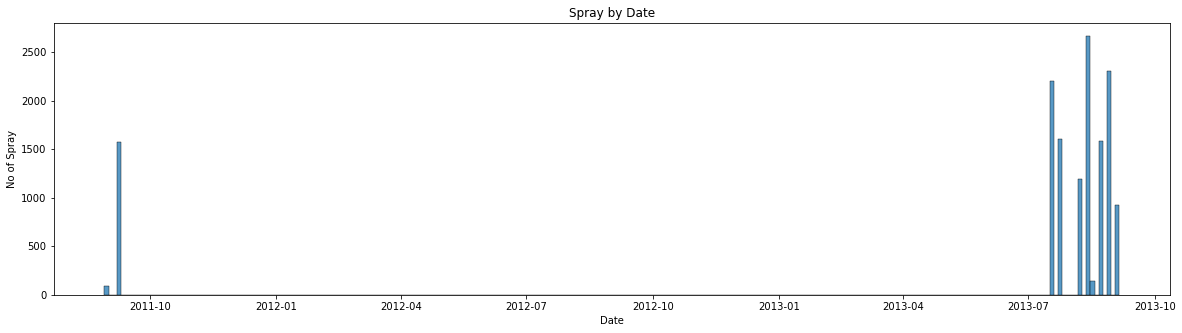

In [32]:
plt.figure(figsize=(20,5))
sns.histplot(df_spray["Date"])
plt.xlabel('Date')
plt.ylabel('No of Spray')
plt.title("Spray by Date")
plt.show();

***only 2 days of Spray in 2011 and 8 days of spray in 2013***

In [33]:
def dbs_cluster(df): 
    '''
    parameter: dataframe with latitude and longitude
    return the label
    '''
    latlong = df[['Latitude', 'Longitude']] 
    dbs = DBSCAN(eps=.03, min_samples=5).fit(latlong) 
    return dbs.labels_ 

In [34]:
df_spray_2011 = df_spray[pd.DatetimeIndex(df_spray['Date']).year == 2011]
df_spray_2013 = df_spray[pd.DatetimeIndex(df_spray['Date']).year == 2013]

In [35]:
#create cluster per year
df_spray_2011["label"] = dbs_cluster(df_spray_2011).copy()
df_spray_2013["label"] = dbs_cluster(df_spray_2013).copy()

<ipython-input-35-d1e5585756ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spray_2011["label"] = dbs_cluster(df_spray_2011).copy()
<ipython-input-35-d1e5585756ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spray_2013["label"] = dbs_cluster(df_spray_2013).copy()


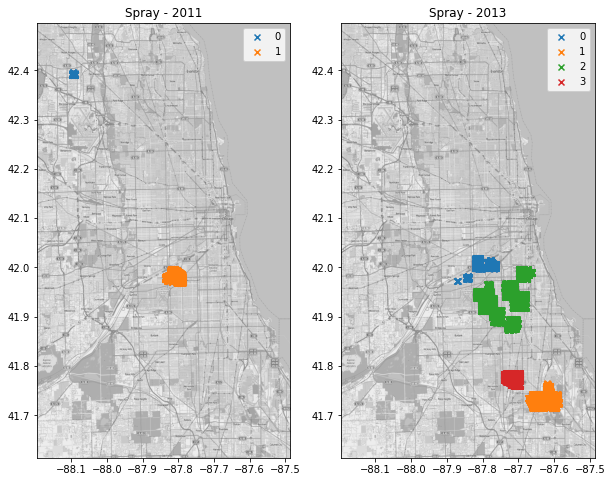

In [36]:
#visualize spray data (and cluster using DBSCAN)

#use map data provided by kaggle
mapdata = np.loadtxt('../datasets/mapdata_copyright_openstreetmap_contributors.txt')  

#set dimensions of the plot
lon_lat_box = (df_spray['Longitude'].min()-.1, df_spray['Longitude'].max()+.1
               , df_spray['Latitude'].min()-.1, df_spray['Latitude'].max()+.1)

#create two chart, one for 2011 and one for 2013
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

#map
ax[0].imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box)
ax[1].imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box)

#data
#ax[0].scatter(df_spray_2011['Longitude'], df_spray_2011['Latitude'], marker='x', label='Spray', color='b');
#ax[1].scatter(df_spray_2013['Longitude'], df_spray_2013['Latitude'], marker='x', label='Spray', color='b');

#plot 2011
for i in df_spray_2011['label'].unique():  
    ax[0].scatter(df_spray_2011[df_spray_2011['label'] == i]['Longitude'], 
               df_spray_2011[df_spray_2011['label'] == i]['Latitude'], 
               label=i, marker='x')

#plot for 2013
for i in df_spray_2013['label'].unique():  
    ax[1].scatter(df_spray_2013[df_spray_2013['label'] == i]['Longitude'], 
               df_spray_2013[df_spray_2013['label'] == i]['Latitude'], 
               label=i, marker='x')
    
#titles
ax[0].set_title('Spray - 2011');
ax[1].set_title('Spray - 2013');

#show legend
ax[0].legend();
ax[1].legend();

In [37]:

df_spray.to_csv("../datasets/cleaned_spray.csv", index=False)

In [38]:
#train Data Cleaning/EDA
#assigned to andrea

## Training Dataset

In [39]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [40]:
df_train.shape

(10506, 12)

In [41]:
df_train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [42]:
df_train

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1
10502,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0
10503,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0
10504,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,5,0


In [43]:
df_train.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

#### Changing the data type for Date column

In [44]:
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [45]:
df_train.dtypes

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
dtype: object

#### Removing unrequired columns

In [46]:
#unrequired columns will be dropped
#add Black back to training data
drop_col = ['Address', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy']

[df_train.drop(col, axis=1, inplace=True) for col in drop_col]

[None, None, None, None]

#### Check for duplicates in the data

In [47]:
df_train[df_train.duplicated(keep=False)]
#df_train.duplicated()

,Date,Species,Block,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
98,2007-06-26,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,1,0
99,2007-06-26,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,1,0
293,2007-07-11,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,50,0
295,2007-07-11,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,50,0
350,2007-07-11,CULEX PIPIENS/RESTUANS,35,T158,41.682587,-87.707973,50,0
...,...,...,...,...,...,...,...,...
10124,2013-09-06,CULEX PIPIENS/RESTUANS,10,T900,41.974689,-87.890615,50,1
10259,2013-09-12,CULEX PIPIENS/RESTUANS,10,T900,41.974689,-87.890615,50,0
10262,2013-09-12,CULEX PIPIENS/RESTUANS,10,T900,41.974689,-87.890615,50,0
10391,2013-09-19,CULEX PIPIENS,10,T900,41.974689,-87.890615,13,0


There are quite a number of duplicates in the data. This is due to the limits in data collection, the number of mosquitoes captured for each row seems to be limited to 50. However, this happened because address were dropped previously. In other words, it happened to have 50 mosquitoes in different address. Thus, there is a need to sum it up at the later part. 

#### Presence of West Nile Virus

In [48]:
df_train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

The training data collected in 2007, 2009, 2011 and 2013 showed 94.75% of no West Nile Virus present in mosquitoes and and 5.24% with West Nile Virus present. 

### Presence of West Nile Virus (2007 - 2013)

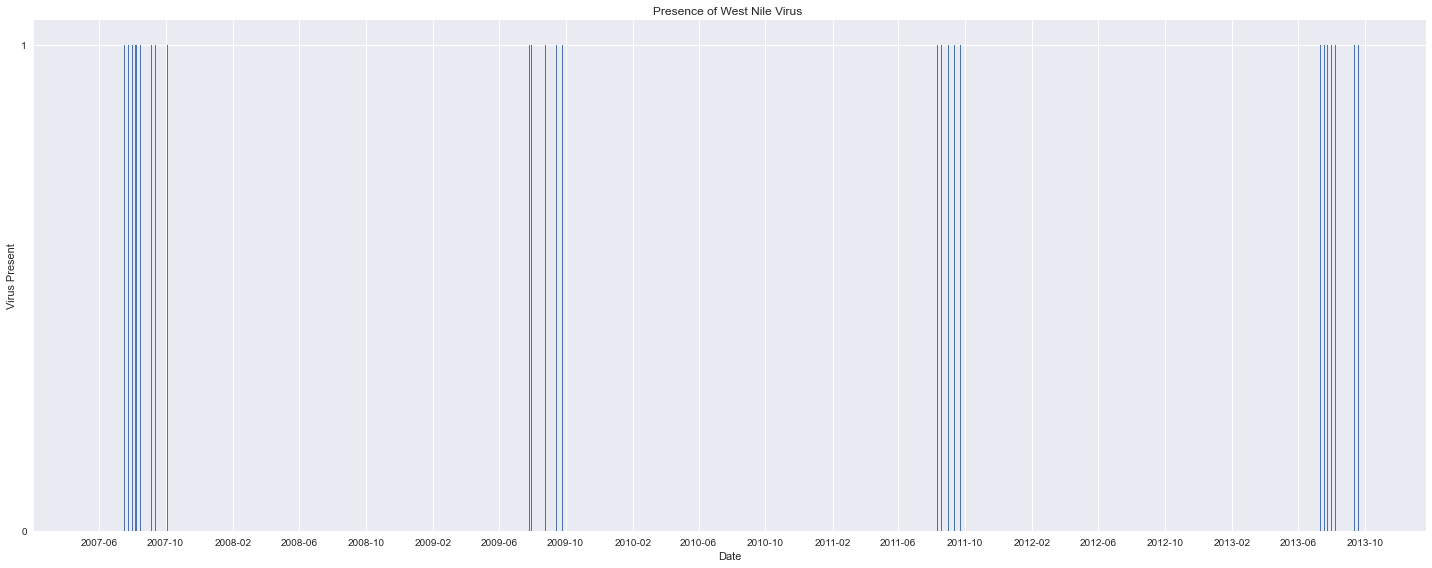

In [49]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20, 8))

ax.bar(df_train['Date'],
       df_train['WnvPresent'],)

ax.set(xlabel="Date",
       ylabel="Virus Present",
       title="Presence of West Nile Virus ")

date_form = DateFormatter("%m-%y")
ax.set_yticks([0,1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 4))
plt.tight_layout()
plt.show()

The training data reflected the seasonality of the virus, with the virus being present between July and October. There were some exceptions with the virus not present in certain years - 2008, 2010, 2012. The training data set consists of data from 2007, 2009, 2011 and 2013. 

### Presence of West Nile Virus in traps - Month

In [50]:
df_train['year'] = df_train['Date'].dt.year
df_train['month'] = df_train['Date'].dt.month

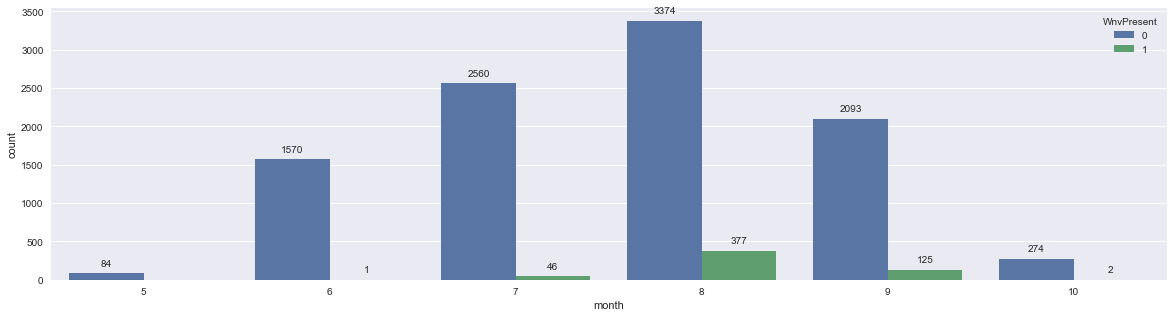

In [51]:
plt.figure(figsize=(20,5))

splot = sns.countplot(data = df_train, x = 'month', hue='WnvPresent')


for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Delving deeper within the specific months, it was noticed that West Nile Virus is present within mosquitoes during July, August and September. With a higher numbers of West Nile Virus present in mosquitoes in August as compared to July and September. 

The data within the training set also reaffirmed the collection process in which mosquito traps being scattered across the city from May to October. 

### Presence of West Nile Virus in traps - Year

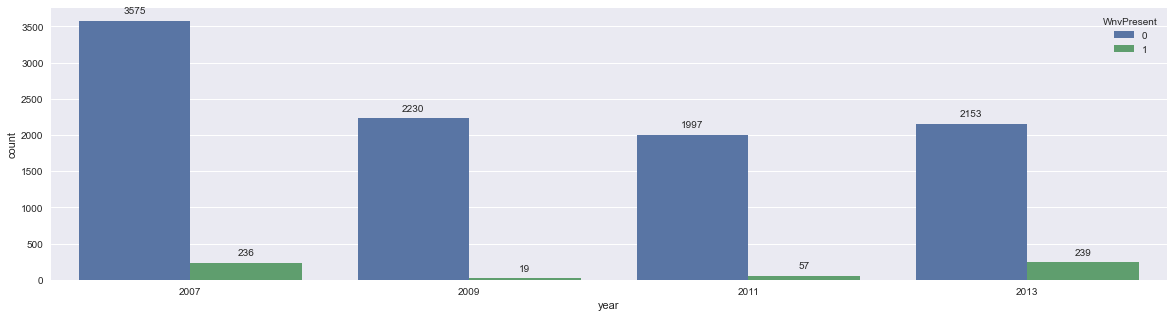

In [52]:
plt.figure(figsize=(20,5))

splot = sns.countplot(data = df_train, x = 'year', hue = 'WnvPresent')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Breaking down within the specific years, we were able to notice that 2007 and 2013 saw higher cases of mosquitoes with West Nile Virus present, with 200 more cases while 2009 and 2013 saw less than 60 cases. 

Comparing the training dataset with the spray data set, we were able to notice while frequency of sprays were much higher in 2013 as compared to 2011, the number of traps with mosquitoes carrying West Nile Virus is 4 times higher than 2011. 

### Types of Mosquitoes captured in traps

In [53]:
df_train['Species'].value_counts(normalize=True)

CULEX PIPIENS/RESTUANS    0.452313
CULEX RESTUANS            0.260803
CULEX PIPIENS             0.256901
CULEX TERRITANS           0.021131
CULEX SALINARIUS          0.008186
CULEX TARSALIS            0.000571
CULEX ERRATICUS           0.000095
Name: Species, dtype: float64

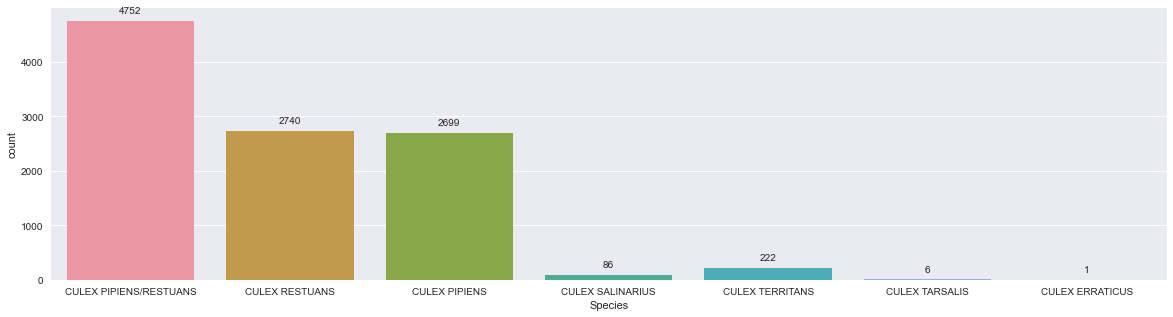

In [54]:
plt.figure(figsize=(20,5))

splot = sns.countplot(data = df_train, x = 'Species')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Out of the 6 different mosquito species caught within the traps in 2007, 2009, 2011 and 2013,  45.23% of cases included mosquitoes that were Culex Pipens/ Restuans (combination of both Culex Restuans & Culex Pipiens), followed by Culex Restuans (26.08%) and Culex Pipiens (25.69%). 

Next, we will be exploring whether certain species are more likely to carrying the West Nile Virus. 

### Counts of traps with mosquitoes carrying West Nile Virus

In [55]:
train_present = df_train.loc[df_train['WnvPresent']==1]
train_present

,Date,Species,Block,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,year,month
553,2007-07-18,CULEX PIPIENS/RESTUANS,38,T215,41.686398,-87.531635,50,1,2007,7
603,2007-07-25,CULEX PIPIENS/RESTUANS,12,T115,41.673408,-87.599862,50,1,2007,7
611,2007-07-25,CULEX PIPIENS/RESTUANS,12,T115,41.673408,-87.599862,50,1,2007,7
618,2007-07-25,CULEX PIPIENS,12,T115,41.673408,-87.599862,50,1,2007,7
660,2007-07-25,CULEX PIPIENS,12,T115,41.673408,-87.599862,50,1,2007,7
...,...,...,...,...,...,...,...,...,...,...
10388,2013-09-19,CULEX PIPIENS/RESTUANS,10,T900,41.974689,-87.890615,27,1,2013,9
10439,2013-09-26,CULEX PIPIENS,46,T003,41.964242,-87.757639,3,1,2013,9
10462,2013-09-26,CULEX PIPIENS/RESTUANS,63,T155,41.776156,-87.778927,4,1,2013,9
10484,2013-09-26,CULEX PIPIENS/RESTUANS,10,T900,41.974689,-87.890615,39,1,2013,9


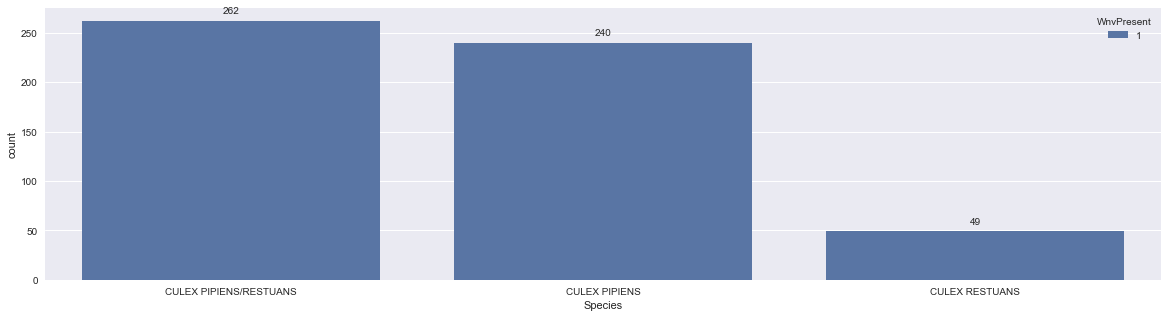

In [56]:
plt.figure(figsize=(20,5))

splot = sns.countplot(data = train_present, x = 'Species', hue='WnvPresent')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Species tested carrying the West Nile Virus are primarily three main species - Culex Pipiens/Restuans, Culex Pipiens and Culex Restuans

### Counts of species captured in traps over the years

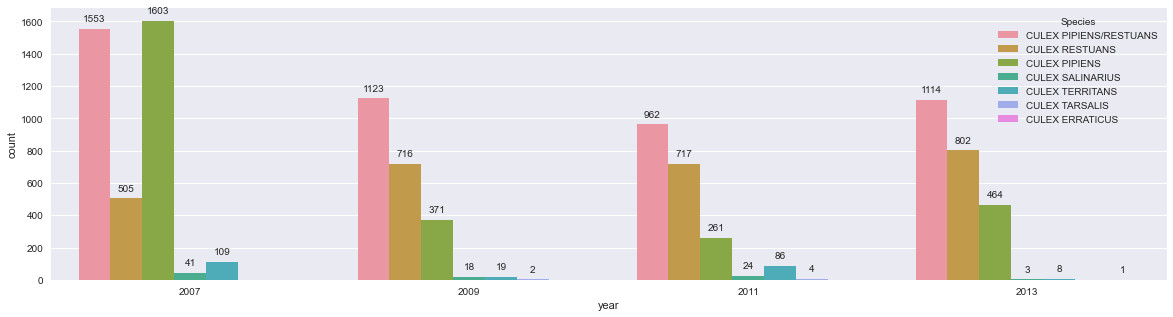

In [57]:
plt.figure(figsize=(20,5))

splot = sns.countplot(data = df_train, x = 'year', hue = 'Species')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Culex Pipiens/ Resturans, Culex Restuans and Culex Pipiens were the three main species seen in the training dataset. This was seen with these three species taking up the bulk of the number of cases of mosquitoes captured in traps in 2007, 2009, 2011 and 2013. 


2007 saw Culex Pipiens taking up 42% of traps sampled with mosquitoes caught. However in 2009, 2011 and 2013, Culex Pipiens/Restuans represented the bulk of the traps sampled - (49.93% in 2009, 46.83% in 2011 and 46.59% in 2013). Furthermore, the number of traps has decreased, 2009, 2011 and 2013 reported less traps as compared to 2007. 

### Sum of Mosquitoes (Year, Month)

In [58]:
mos_yearmth = df_train.groupby(['year', 'month'])['NumMosquitos'].agg(['sum'])
mos_yearmth

sum
year month       
2007 5         40
     6        428
     7       7199
     8      40015
     9       9300
     10      1706
2009 5        190
     6       7390
     7       8833
     8       2346
     9       2137
     10       212
2011 6       4049
     7       8445
     8       2968
     9       3337
2013 6       4711
     7      12771
     8      12707
     9       6255

In [59]:
mos_year = df_train.groupby(['year'])['NumMosquitos'].agg(['sum'])
mos_year

,sum
year,
2007,58688
2009,21108
2011,18799
2013,36444


Text(0.5, 1.0, 'Total sum of mosquitoes by Year, Month')

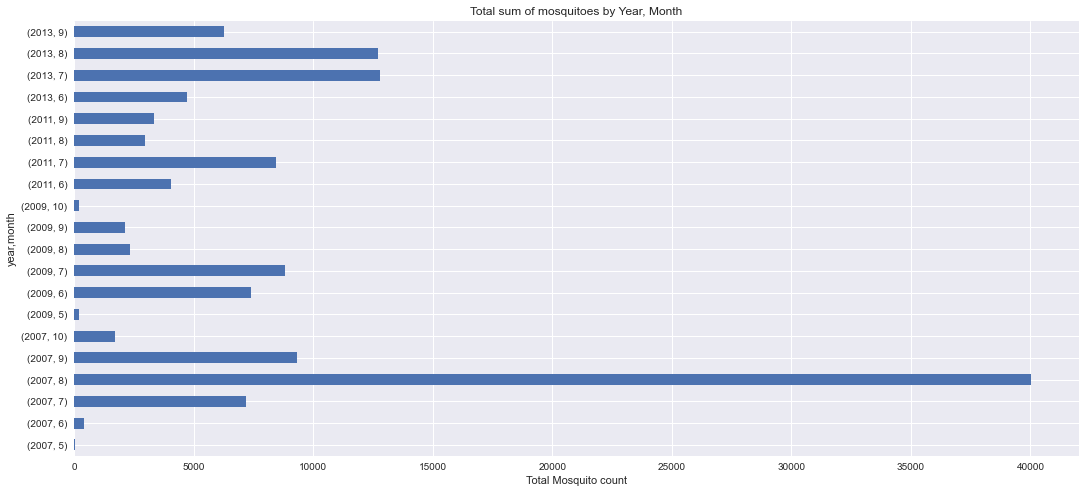

In [60]:
plt.figure(figsize=(18, 8))
mos_yearmth['sum'].plot(kind="barh")
plt.xlabel('Total Mosquito count')
plt.title('Total sum of mosquitoes by Year, Month')

August 2007 saw the highest number of mosquitoes caught with more than 40,000 mosquitoes followed by july and august 2013 with more than 12,000 mosquitoes caught. 

In [61]:
sss = df_train.groupby(['year', 'month', 'Species','WnvPresent'], as_index=False).agg({'NumMosquitos': 'sum'})
sss

,year,month,Species,WnvPresent,NumMosquitos
0,2007,5,CULEX PIPIENS,0,1
1,2007,5,CULEX PIPIENS/RESTUANS,0,10
2,2007,5,CULEX RESTUANS,0,29
3,2007,6,CULEX PIPIENS,0,20
4,2007,6,CULEX PIPIENS/RESTUANS,0,121
...,...,...,...,...,...
120,2013,9,CULEX PIPIENS,1,771
121,2013,9,CULEX PIPIENS/RESTUANS,0,2090
122,2013,9,CULEX PIPIENS/RESTUANS,1,911
123,2013,9,CULEX RESTUANS,0,191


In [62]:
cols = ['year', 'month']
sss['year_month'] = sss[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
sss.head()

,year,month,Species,WnvPresent,NumMosquitos,year_month
0,2007,5,CULEX PIPIENS,0,1,2007_5
1,2007,5,CULEX PIPIENS/RESTUANS,0,10,2007_5
2,2007,5,CULEX RESTUANS,0,29,2007_5
3,2007,6,CULEX PIPIENS,0,20,2007_6
4,2007,6,CULEX PIPIENS/RESTUANS,0,121,2007_6


### Sum of Mosquitoes (Year, Month) by Species

<AxesSubplot:xlabel='year_month', ylabel='NumMosquitos'>

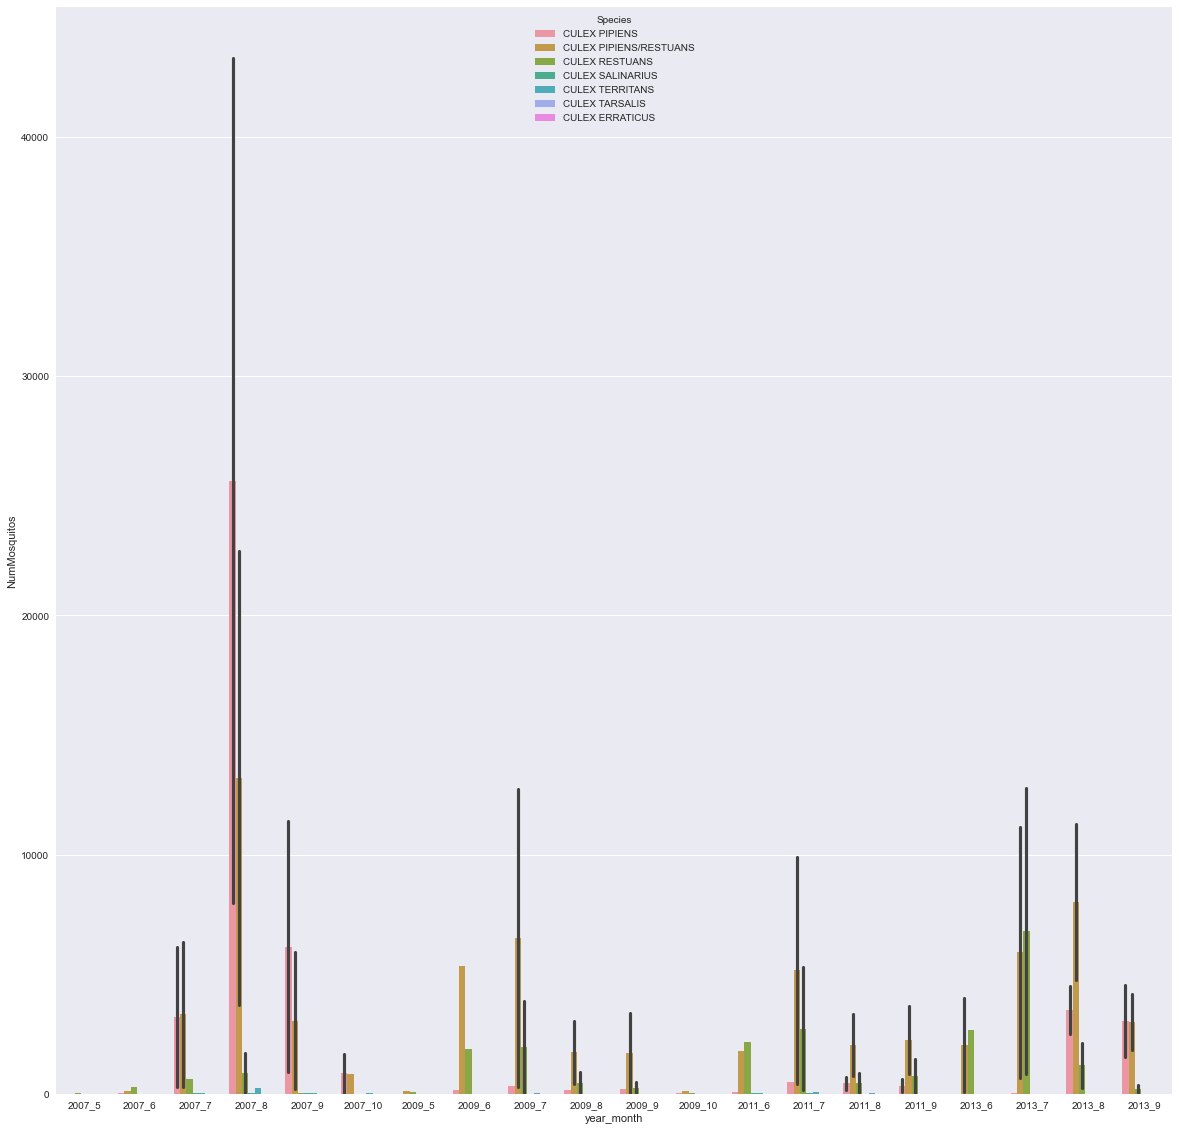

In [63]:
plt.figure(figsize=(20, 20))
sns.barplot(x="year_month", y="NumMosquitos", data=sss, hue = 'Species', estimator=sum)

In August 2007, more than 25,000 Culex Pipens was caught, which was 10,000 more than the next highest number of mosquito species (Culex Pipiens/Restuans) caught in the same month. 

Taking a closer look at the specific years- it was noticed that in 2009, majority of species caught were Culux Pipiens and Culux Pipiens/Restuans. In 2009 and 2011 and 2013(june, july) , majority of species caught belonged to Culex Pipiens/Restuans and Culex Restuans while in August and September 2013, majority of species caught were Culex Pipiens and Culex Pipens/Restuans.

### Traps

In [64]:
trap_count = df_train['Trap'].nunique()

print( f"There are {trap_count} unique number of traps in the training dataset")

There are 136 unique number of traps in the training dataset


In [65]:
trap_present = train_present.groupby('Trap')['NumMosquitos'].agg(['sum','count'])
trap_present.index.name = 'Trap'

In [66]:

top_10 = trap_present.sort_values(by="sum", ascending=False).head(10)
#top_10

#### Visualizing the count of traps with presence of West Nile Virus in mosquitoes

<AxesSubplot:ylabel='Trap'>

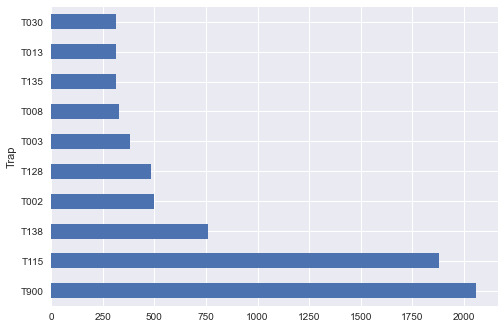

In [67]:
top_10['sum'].plot(kind="barh")

The top 2 Traps with the highest count of mosquitoes with west nile virus are T900 and T115, with more than 1750 counts.

### Addressing 50 mosquitoes per row limit

Pulling up duplicate rows with the same date, species and location. 


In [68]:
#Filtering rows that are duplicated based on these columns - Date, Species, Latitude, Longitude and WnvPresent
df_train.loc[df_train.duplicated(subset=['Date', 'Species', 'Latitude', 'Longitude','WnvPresent'], keep=False)]

,Date,Species,Block,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,year,month
98,2007-06-26,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,1,0,2007,6
99,2007-06-26,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,1,0,2007,6
280,2007-07-11,CULEX RESTUANS,79,T015,41.974089,-87.824812,1,0,2007,7
281,2007-07-11,CULEX RESTUANS,79,T015,41.974089,-87.824812,2,0,2007,7
293,2007-07-11,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,50,0,2007,7
...,...,...,...,...,...,...,...,...,...,...
10443,2013-09-26,CULEX PIPIENS/RESTUANS,11,T047,41.868142,-87.696269,9,0,2013,9
10486,2013-09-26,CULEX PIPIENS,10,T900,41.974689,-87.890615,16,0,2013,9
10487,2013-09-26,CULEX PIPIENS,10,T900,41.974689,-87.890615,9,0,2013,9
10488,2013-09-26,CULEX PIPIENS,10,T900,41.974689,-87.890615,11,0,2013,9


In [69]:
# grouping every col within the df to remove the duplicated rows

df_train = df_train.groupby([col for col in df_train.columns if col not in ['NumMosquitos']], as_index=False).sum().reindex()


In [70]:
df_train.duplicated().sum()

0

In [71]:
df_train.shape

(8610, 10)

In [72]:
df_train

,Date,Species,Block,Trap,Latitude,Longitude,WnvPresent,year,month,NumMosquitos
0,2007-05-29,CULEX PIPIENS,22,T096,41.731922,-87.677512,0,2007,5,1
1,2007-05-29,CULEX PIPIENS/RESTUANS,11,T048,41.867108,-87.654224,0,2007,5,1
2,2007-05-29,CULEX PIPIENS/RESTUANS,21,T050,41.919343,-87.694259,0,2007,5,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,22,T054,41.921965,-87.632085,0,2007,5,2
4,2007-05-29,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,0,2007,5,1
...,...,...,...,...,...,...,...,...,...,...
8605,2013-09-26,CULEX RESTUANS,13,T209,41.740641,-87.546587,0,2013,9,1
8606,2013-09-26,CULEX RESTUANS,40,T221,41.659112,-87.538693,0,2013,9,5
8607,2013-09-26,CULEX RESTUANS,45,T220,41.963976,-87.691810,0,2013,9,8
8608,2013-09-26,CULEX RESTUANS,50,T082,41.803423,-87.642984,0,2013,9,2


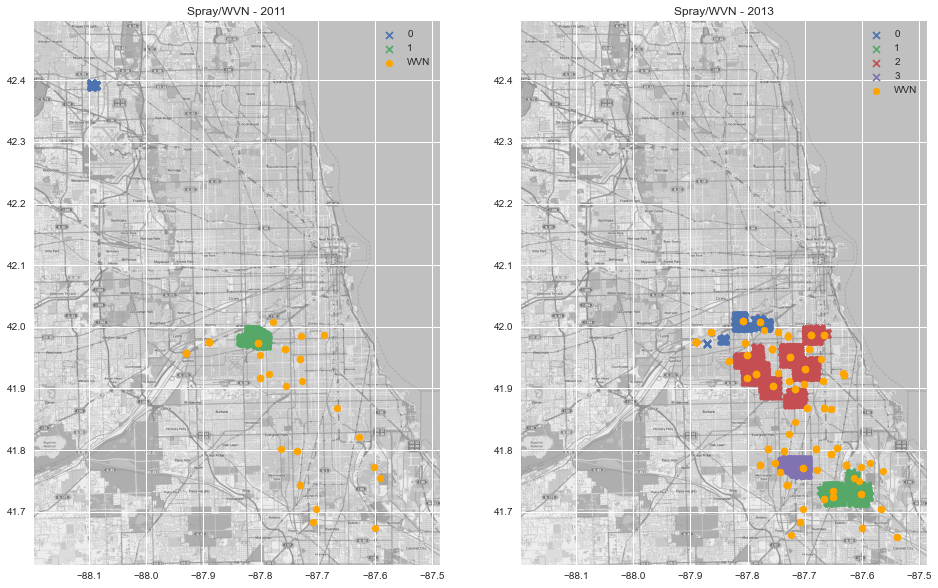

In [73]:
#Visualize if Sprayed area has less WVN cases

df_train_2011 = df_train[(pd.DatetimeIndex(df_train['Date']).year == 2011) & (df_train['WnvPresent'] > 0 )]
df_train_2013 = df_train[(pd.DatetimeIndex(df_train['Date']).year == 2013) & (df_train['WnvPresent'] > 0 )]

#use map data provided by kaggle
mapdata = np.loadtxt('../datasets/mapdata_copyright_openstreetmap_contributors.txt')  

#set dimensions of the plot
lon_lat_box = (df_spray['Longitude'].min()-.1, df_spray['Longitude'].max()+.1
, df_spray['Latitude'].min()-.1, df_spray['Latitude'].max()+.1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,10))


#map
ax[0].imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box)
ax[1].imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box)

#data
#plot spray 2011
for i in df_spray_2011['label'].unique():  
    ax[0].scatter(df_spray_2011[df_spray_2011['label'] == i]['Longitude'], 
               df_spray_2011[df_spray_2011['label'] == i]['Latitude'], 
               label=i, marker='x')

#plot spray 2013
for i in df_spray_2013['label'].unique():  
    ax[1].scatter(df_spray_2013[df_spray_2013['label'] == i]['Longitude'], 
               df_spray_2013[df_spray_2013['label'] == i]['Latitude'], 
               label=i, marker='x')

#WVN 
ax[0].scatter(df_train_2011['Longitude'], df_train_2011['Latitude'], marker='o', label='WVN', color='orange');
ax[1].scatter(df_train_2013['Longitude'], df_train_2013['Latitude'], marker='o', label='WVN', color='orange');

#titles
ax[0].set_title('Spray/WVN - 2011');
ax[1].set_title('Spray/WVN - 2013');

#show legend
ax[0].legend();
ax[1].legend();

*Above is the spray location and the presence of WVN , further analysis needed to check if the area that were sprayed have any impact on the number of mosquitos or presence of WNV*

In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          8610 non-null   datetime64[ns]
 1   Species       8610 non-null   object        
 2   Block         8610 non-null   int64         
 3   Trap          8610 non-null   object        
 4   Latitude      8610 non-null   float64       
 5   Longitude     8610 non-null   float64       
 6   WnvPresent    8610 non-null   int64         
 7   year          8610 non-null   int64         
 8   month         8610 non-null   int64         
 9   NumMosquitos  8610 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 672.8+ KB


In [75]:
df_merge = pd.merge(left=df_train, right=df_weather, how="inner", on="Date")
df_merge.shape

(8610, 24)

In [76]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          8610 non-null   datetime64[ns]
 1   Species       8610 non-null   object        
 2   Block         8610 non-null   int64         
 3   Trap          8610 non-null   object        
 4   Latitude      8610 non-null   float64       
 5   Longitude     8610 non-null   float64       
 6   WnvPresent    8610 non-null   int64         
 7   year          8610 non-null   int64         
 8   month         8610 non-null   int64         
 9   NumMosquitos  8610 non-null   int64         
 10  Tavg          8610 non-null   float64       
 11  Depart        8610 non-null   float64       
 12  DewPoint      8610 non-null   float64       
 13  WetBulb       8610 non-null   float64       
 14  PrecipTotal   8610 non-null   float64       
 15  StnPressure   8610 non-null   float64 

<AxesSubplot:>

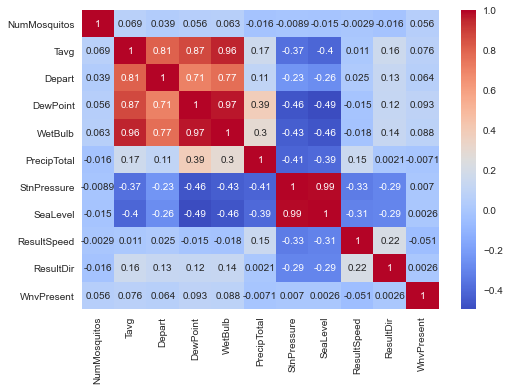

In [77]:
# Looking for correlation against WmnPresent
features = ['Species','Trap','NumMosquitos','Tavg','Depart','DewPoint','WetBulb','PrecipTotal','StnPressure','SeaLevel','ResultSpeed','ResultDir','CodeSum_set','WnvPresent']
sns.heatmap(df_merge[features].corr(), annot=True, cmap='coolwarm')

#### Decision of dropping columns which have weak correlation with WmnPresent.

we are dropping features that has less than 0.05 or more than -0.05 against WmnPresent. <br>
Afterwhich, we have indentified ['StnPressure','SeaLevel','Depart','WetBulb','ResultDir','PrecipTotal']  to be dropped. <br>
However, we noticed 'PrecipTotal' has is an indicator to identify whether the day has heavy rain or no rain which is a critical influence of mosquitoes activity (Mosquitoes are weak flying insect and if there is heavy rain, it will damage their wings thus heavy rain affects mosquitoes to staying indoor).Therefore, we will keep 'PrecipTotal' as one of the features.


In [78]:
df_merge.drop(columns=['StnPressure','Depart','WetBulb','ResultDir'], inplace=True)

In [79]:
df_merge

,Date,Species,Block,Trap,Latitude,Longitude,WnvPresent,year,month,NumMosquitos,Tavg,DewPoint,PrecipTotal,SeaLevel,ResultSpeed,AvgSpeed,Sunrise,Sunset,CodeSum_set,Month
0,2007-05-29,CULEX PIPIENS,22,T096,41.731922,-87.677512,0,2007,5,1,75.5,58.5,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May
1,2007-05-29,CULEX PIPIENS/RESTUANS,11,T048,41.867108,-87.654224,0,2007,5,1,75.5,58.5,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May
2,2007-05-29,CULEX PIPIENS/RESTUANS,21,T050,41.919343,-87.694259,0,2007,5,1,75.5,58.5,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May
3,2007-05-29,CULEX PIPIENS/RESTUANS,22,T054,41.921965,-87.632085,0,2007,5,2,75.5,58.5,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May
4,2007-05-29,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,0,2007,5,1,75.5,58.5,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605,2013-09-26,CULEX RESTUANS,13,T209,41.740641,-87.546587,0,2013,9,1,64.0,52.0,0.0,30.04,3.95,4.40,0543,1742,'BR',September
8606,2013-09-26,CULEX RESTUANS,40,T221,41.659112,-87.538693,0,2013,9,5,64.0,52.0,0.0,30.04,3.95,4.40,0543,1742,'BR',September
8607,2013-09-26,CULEX RESTUANS,45,T220,41.963976,-87.691810,0,2013,9,8,64.0,52.0,0.0,30.04,3.95,4.40,0543,1742,'BR',September
8608,2013-09-26,CULEX RESTUANS,50,T082,41.803423,-87.642984,0,2013,9,2,64.0,52.0,0.0,30.04,3.95,4.40,0543,1742,'BR',September


In [80]:

#check to make sure there is no more missing data
assert df_merge.isnull().sum().sum() == 0 

#save our dataset for further processing (feature engineering)
df_merge.to_csv("../datasets/cleaned_traindf.csv", index=False)

We have decided to drop the spray dataset and merge the training dataset with the weather dataset. 

This decision was made due to various reasons. 
1) There is only data in the spray dataset for 2 years (2011 and 2013)
2) While frequency of sprays are much higher in 2013 as compared to 2011, the number of traps with mosquitoes carrying West Nile Virus is 4 times higher than 2011. Also, the sum of mosquitoes caught in 2013 is higher than 2011 (1.94X higher than 2011) which shows that the sprays may not be effective in killing the mosquitoes and reducing West Nile Virus in the area.

In [81]:
# merge with Spray dataset
df_spray["is_spray"] = 1
df_spray.rename(columns={'Date':'Spray_Date'},inplace=True)
df_spray["Latitude"] = df_spray["Latitude"].round(6)
df_spray["Longitude"] = df_spray["Longitude"].round(6)
df_mwspray = pd.merge(left=df_merge, right=df_spray, how="left", left_on=["Latitude","Longitude"], right_on=["Latitude","Longitude"])
df_mwspray.shape

(8610, 22)

In [82]:
df_mwspray.to_csv("../datasets/cleaned_traindf w spray.csv", index=False)
df_mwspray

,Date,Species,Block,Trap,Latitude,Longitude,WnvPresent,year,month,NumMosquitos,...,PrecipTotal,SeaLevel,ResultSpeed,AvgSpeed,Sunrise,Sunset,CodeSum_set,Month,Spray_Date,is_spray
0,2007-05-29,CULEX PIPIENS,22,T096,41.731922,-87.677512,0,2007,5,1,...,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May,NaT,NaN
1,2007-05-29,CULEX PIPIENS/RESTUANS,11,T048,41.867108,-87.654224,0,2007,5,1,...,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May,NaT,NaN
2,2007-05-29,CULEX PIPIENS/RESTUANS,21,T050,41.919343,-87.694259,0,2007,5,1,...,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May,NaT,NaN
3,2007-05-29,CULEX PIPIENS/RESTUANS,22,T054,41.921965,-87.632085,0,2007,5,2,...,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May,NaT,NaN
4,2007-05-29,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,0,2007,5,1,...,0.0,30.10,5.80,6.95,0421,1917,"'BR','HZ'",May,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605,2013-09-26,CULEX RESTUANS,13,T209,41.740641,-87.546587,0,2013,9,1,...,0.0,30.04,3.95,4.40,0543,1742,'BR',September,NaT,NaN
8606,2013-09-26,CULEX RESTUANS,40,T221,41.659112,-87.538693,0,2013,9,5,...,0.0,30.04,3.95,4.40,0543,1742,'BR',September,NaT,NaN
8607,2013-09-26,CULEX RESTUANS,45,T220,41.963976,-87.691810,0,2013,9,8,...,0.0,30.04,3.95,4.40,0543,1742,'BR',September,NaT,NaN
8608,2013-09-26,CULEX RESTUANS,50,T082,41.803423,-87.642984,0,2013,9,2,...,0.0,30.04,3.95,4.40,0543,1742,'BR',September,NaT,NaN


In [83]:
df_spray

,Spray_Date,Latitude,Longitude,is_spray
0,2011-08-29,42.391623,-88.089163,1
1,2011-08-29,42.391348,-88.089163,1
2,2011-08-29,42.391022,-88.089157,1
3,2011-08-29,42.390637,-88.089158,1
4,2011-08-29,42.390410,-88.088858,1
...,...,...,...,...
14830,2013-09-05,42.006587,-87.812355,1
14831,2013-09-05,42.006192,-87.816015,1
14832,2013-09-05,42.006022,-87.817392,1
14833,2013-09-05,42.005453,-87.817423,1


## Test Dataset

In [84]:
#do the same for test dataset

In [85]:
#remove the columns
[df_test.drop(col, axis=1, inplace=True) for col in drop_col]

[None, None, None, None]

In [86]:
#create date fields
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['year'] = df_test['Date'].dt.year
df_test['month'] = df_test['Date'].dt.month

In [87]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Id         116293 non-null  int64         
 1   Date       116293 non-null  datetime64[ns]
 2   Species    116293 non-null  object        
 3   Block      116293 non-null  int64         
 4   Trap       116293 non-null  object        
 5   Latitude   116293 non-null  float64       
 6   Longitude  116293 non-null  float64       
 7   year       116293 non-null  int64         
 8   month      116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 8.0+ MB


In [88]:
df_merge_test = pd.merge(left=df_test, right=df_weather, how="left", on="Date")
df_merge_test.shape

(116293, 23)

In [89]:
df_merge_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Id           116293 non-null  int64         
 1   Date         116293 non-null  datetime64[ns]
 2   Species      116293 non-null  object        
 3   Block        116293 non-null  int64         
 4   Trap         116293 non-null  object        
 5   Latitude     116293 non-null  float64       
 6   Longitude    116293 non-null  float64       
 7   year         116293 non-null  int64         
 8   month        116293 non-null  int64         
 9   Tavg         116293 non-null  float64       
 10  Depart       116293 non-null  float64       
 11  DewPoint     116293 non-null  float64       
 12  WetBulb      116293 non-null  float64       
 13  PrecipTotal  116293 non-null  float64       
 14  StnPressure  116293 non-null  float64       
 15  SeaLevel     116293 non-null  floa

In [90]:
# following dropped columns from df_merge dataset
df_merge_test.drop(columns=['StnPressure','Depart','WetBulb','ResultDir'], inplace=True)

In [91]:
#check to make sure there is no more missing data
assert df_merge_test.isnull().sum().sum() == 0 

#save our dataset for further processing (feature engineering)
df_merge_test.to_csv("../datasets/cleaned_testdf.csv", index=False)

In [92]:
### END OF DATA CLEANING ####

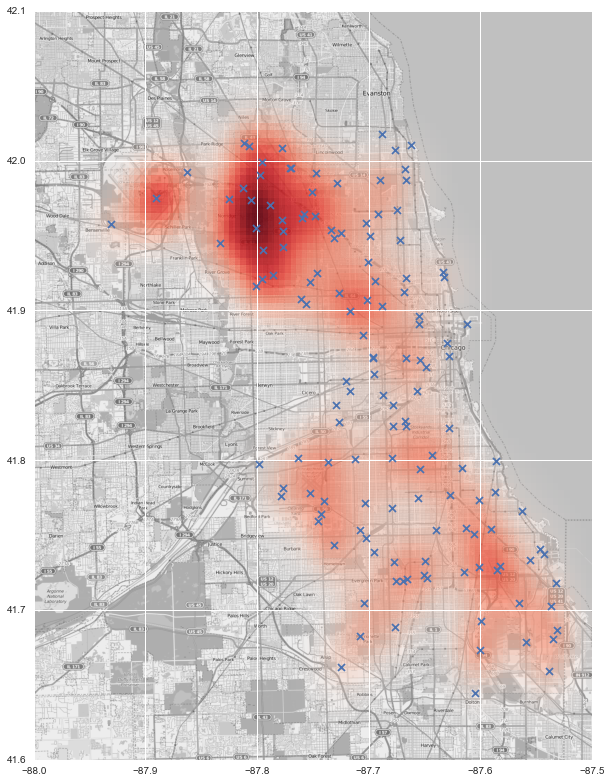

In [93]:
#https://www.kaggle.com/code/khyh00/west-nile-heatmap/script

from sklearn.neighbors import KernelDensity

traps = df_train[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

# these are needed for plotting densities over map image,
# it changes alpha channel?

# see,
# Meaning of the colormap._lut list in matplotlib.color
# http://stackoverflow.com/questions/18035411/meaning-of-the-colormap-lut-list-in-matplotlib-color

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]


aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1) # xmin, xmax, ymin, ymax

sigthings = traps[traps['WnvPresent'] > 0]
sigthings = sigthings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
X = sigthings[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.02)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plt.imshow(zv, 
           origin='lower', 
           cmap=alpha_cm, 
           extent=lon_lat_box, 
           aspect=aspect)

# -> how to use 'extent' in matplotlib.pyplot.imshow
# http://stackoverflow.com/questions/6999621/how-to-use-extent-in-matplotlib-pyplot-imshow

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3abded61-2db4-446b-a02d-565b62921f1b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>